# IMPORTING LIBRARIES, FUNCTIONS AND CONVERSION TABLES

In [1]:
# Data parsing and engineering.
import pandas as pd
import re
import numpy as np
from tariff_functions import sanitize_entry, standardize_duty, extract_unit, get_converted_quantity
from conversion_tables import tariff_unit_to_description, unit_conversion_map, tas

# Linear regression and visualizations
import statsmodels.api as sm
import patsy
from patsy import build_design_matrices
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

In [20]:
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)

# IMPORTING DATASETS - 2023 & 2024

In [2]:
# HTS8 -> NAICS4
ct = pd.read_excel('impconcord25.xlsx', usecols=['commodity', 'naics'], dtype={'commodity': str})
ct.rename(columns={'commodity':'hts8'}, inplace=True)
# Slicing codes to get hts8 and naics4.
# Creating a hash table whose keys are hts-8 and values are naics4 codes.
conversion_dict = {}
for _, row in ct.iterrows():
    row['hts8']=row['hts8'][:8]
    row['naics']=row['naics'][:4]
    conversion_dict.setdefault(row['hts8'], row['naics'])

In [3]:
# Importing the tariff database.

tariff_db = pd.read_excel('tariff_database_202405.xlsx',
                          usecols=[
                              'hts8', 'brief_description', 'quantity_1_code', 'quantity_2_code', 'wto_binding_code',
                              'mfn_text_rate', 'col1_special_text', 'col2_text_rate', 'additional_duty'
                          ], dtype={'hts8': str})

# CIF values (USD) and calculated duties.

country_im = pd.read_excel('cif_calc_duties.xlsx', skiprows=2, dtype={'HTS Number': str})
country_im.rename(columns={'2024':'Amount'}, inplace=True)

country_im['Amount'] = pd.to_numeric(country_im['Amount'], errors='coerce')  # "0" => 0
country_im = country_im[country_im['Amount'] != 0] # Ignoring rows whose amounts are equal to zero.

filt_cif = country_im['Data Type'] == 'CIF Import Value'
filt_calc_duties = country_im['Data Type'] == 'Calculated Duties'

cif = country_im.loc[filt_cif]
cd = country_im.loc[filt_calc_duties]

# Quantities by units, necessary to handle specific tariffs.
amount_units = pd.read_excel('amount_units.xlsx', dtype={'HTS Number': str}, skiprows=2)
amount_units.rename(columns={'2024':'Amount'}, inplace=True)

In [4]:
#**********************************************************************************************************************************#
# SAME PROCEDING FOR THE TRAINING YEAR (2023)
#**********************************************************************************************************************************#
tariff_db_2023 = pd.read_excel('tariff database_202307.xlsx',
                               usecols=['hts8', 'brief_description', 'quantity_1_code', 'quantity_2_code',
                                        'wto_binding_code', 'mfn_text_rate', 'col1_special_text', 'col2_text_rate', 'additional_duty'
                                       ], dtype={'hts8': str})
country_im_2023 = pd.read_excel('cif_calc_duties_2023.xlsx', skiprows=2, dtype={'HTS Number': str})
country_im_2023.rename(columns={'2023':'Amount'}, inplace=True)
country_im_2023['Amount'] = pd.to_numeric(country_im_2023['Amount'], errors='coerce')  # "0" diventa 0
country_im_2023 = country_im_2023[country_im_2023['Amount'] != 0]
filt_cif = country_im_2023['Data Type'] == 'CIF Import Value'
filt_calc_duties = country_im_2023['Data Type'] == 'Calculated Duties'
cif_2023 = country_im_2023.loc[filt_cif]
cd_2023 = country_im_2023.loc[filt_calc_duties]
amount_units_2023 = pd.read_excel('amount_units_2023.xlsx', dtype={'HTS Number': str}, skiprows=2)
# The last kwarg is important because the first two rows are descriptive. Actual column names are reported in line 3.
amount_units_2023.rename(columns={'2023':'Amount'}, inplace=True)

In [5]:
# Function to visualize ALL values in a column. Useful when parsing.
def vc(df, col_name):
    pd.set_option('display.max_rows', None)
    return df[col_name].value_counts(dropna=False)

#### No change in conversion table to allow industry comparison across years - same hts codes within each naics

# Deterministic Model

In [10]:
class DeterministicModel():
    # Self -> ibc nested dictionary.
    def __init__ (self, tariff_database, cif, amount_by_unit, trade_agreements, unit_conversion_map, calculated_duties, tariff_unit_to_description):
        self.tariff_database = tariff_database
        self.cif = cif
        self.amount_by_unit = amount_by_unit
        self.calculated_duties = calculated_duties
        self.trade_agreements = trade_agreements
        self.tariff_unit_to_description = tariff_unit_to_description
        self.unit_conversion_map = unit_conversion_map
        # Stateful attributes (avoid globals)
        self.ibc: Dict[str, Dict] = {}  # {hts: {origin_country: {amount_usd, amount_unit, tariff}}}
        self.exception_cache: set = set()
        self.ibc_exceptions: Dict = {}
        self.untracked_exceptions: Dict = {}
        self.exc_list: list = [] # Out of 1103 exceptions in exc_list, there are 190 unique values -> shouldn't the exceptions_cache block this?
    
    def build_ibc(self) -> None:
        """Populate self.ibc with CIF and unit data."""
        self.structure_cif_data()
        self.structure_unit_data()

    def structure_cif_data(self) -> None:
        for _, row in self.cif.iterrows():
            hts = row['HTS Number']
            country = row['Country']
            amount = row['Amount']
            if hts not in self.ibc:
                self.ibc[hts] = {}
            
            self.ibc[hts][country] = {
                'amount_usd': amount,
                'amount_unit': {},
                'tariff': {}
            }
    
    def structure_unit_data(self) -> None:

        # Technicalities about the loop below: iterate through GroupBy object made of (HTS, Country) groups.
        # Integer indexing is dangerous.
        # Only unique combinations of hts and country are returned, hence there is no loss in unit of measure differentiation.
        # The quantities sharing hts, country and unit are summed.
    
        for (hts, country), group in self.amount_by_unit.groupby(['HTS Number', 'Country']):
            unit_data = {'unit1': None, 'quantity1': 0, 'unit2': None, 'quantity2': 0} # Setting up the dictionary.
            for _, row in group.iterrows():
                if row['Data Type'] == 'First Unit of Quantity':
                    unit_data['unit1'] = row['Quantity Description']
                    unit_data['quantity1'] += row['Amount'] or 0
                elif row['Data Type'] == 'Second Unit of Quantity':
                    unit_data['unit2'] = row['Quantity Description']
                    unit_data['quantity2'] += row['Amount'] or 0
        
            # Populate the ibc dictionary.
            self.ibc.setdefault(hts, {}).setdefault(country, {}).update({
                'amount_unit' : unit_data
            })
            

    # resolve_duties() injects the right tariff to each country at given hts8 code, scanning for trade agreements and preferential programs.
    # It calls st_duty() to serve its purpose.
    # The function follows the ranking: FTA -> preferential program -> MFN tariff -> non-MFN tariff
    def resolve_duties(self, hts, entry):
        if hts not in self.ibc:
            return
        # Making sure 'entry' is a string and standardize it.
        entry = sanitize_entry(entry)
        entry = re.sub(r'\s+', ' ', entry).strip().lower()
    
        # Free
        if entry in ('free', 'no change'): # Entry is already stripped and lowercase.
            for country in self.ibc[hts]:
                self.ibc[hts][country]['tariff'] = {'adval': 0.0, 'specific': [], 'unit': None}
    
        # Free trade groups (Free (A,AU,BH,...)) -> what if there is "+10% (KR)" or "$1.02/kg (KR)" after the closing bracket?
        free_trade_groups = re.findall(r'free\s*\(([^)]+)\)', entry, flags=re.IGNORECASE)
        for group in free_trade_groups: # In most cases: 1.
            for code in map(str.strip, group.upper().split(',')):
                if code in self.trade_agreements:
                    for country in self.ibc[hts]: # If the exporting country belongs to a preferential program for given HTS, no duties are applied.
                        if country in self.trade_agreements[code]:
                            self.ibc[hts][country]['tariff'] = {'adval': 0.0, 'specific': [], 'unit': None}
    
        # Country-specific compound duties (e.g. "3.5¢/kg + 5% (KR)")
        pattern = r"""
        (                          # Group 1: tariff component
            \b
            (?!\d{4}\.\d{2}\.\d{2}\b)  # Explicitly excluding 9822.54.74 structures.
            [\d.]+
            (?:¢\/(?:kg|liter)|\$[\d.]+\/kg|%)?
            (?:\s*\+\s*[\d.]+%)?
            (?:\s+of[^)]*)?
        )
        \s*\(([^)]+)\)             # Group 2: preferential group
        """
        matches = re.findall(pattern, entry, flags=re.IGNORECASE | re.VERBOSE)
        for duty_str, groups in matches:
            parsed = standardize_duty(duty_str, self.tariff_unit_to_description)
            for group in map(str.strip, groups.upper().split(',')):
                if group in self.trade_agreements:
                    for country in self.ibc[hts]:
                        if country in self.trade_agreements[group]:
                            self.ibc[hts][country]['tariff'] = parsed
    
        # Fallbacks: MFN and col2
        row = self.tariff_database[self.tariff_database['hts8'] == hts]
        if not row.empty:
            mfn_rate_text = row.iloc[0]['mfn_text_rate']
            col2_rate_text = row.iloc[0]['col2_text_rate']
            try:
                mfn_duty = standardize_duty(mfn_rate_text, self.tariff_unit_to_description)
                col2_duty = standardize_duty(col2_rate_text, self.tariff_unit_to_description)
            except ValueError:
                mfn_duty = col2_duty = {'adval': None, 'specific': [], 'unit': None}
    
            for country in self.ibc[hts]:
                try:
                    current = self.ibc[hts][country].get('tariff', {})
                    
                    if isinstance(current, dict) and current.get('adval') is not None and current.get('specific') is not None:
                        continue
                    """ If 'current' is a dict and contains both non-None 'adval' and 'specific' keys, skip: fully resolved duty. """
        
                    if country in self.trade_agreements.get('MFN', []) and row.iloc[0]['wto_binding_code'] == 'B': # "B" means bound.
                        self.ibc[hts][country]['tariff'] = mfn_duty
                    else:
                        self.ibc[hts][country]['tariff'] = col2_duty
                except AttributeError as e:
                    # Untracked exceptions
                    pass
                    
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^#
    # ENGINE which calls all of the previous functions to fill the tariff entry in ibc.
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^#
    
    def apply_tariffs(self):
        for index, row in self.tariff_database.iterrows():
            hts_code = row['hts8']
            entry_text = row['col1_special_text']
            self.resolve_duties(hts_code, entry_text)

    # Create a dataframe with the results.
    def ibc_to_dataframe(self):
        rows = []
        # O(1) vs O(n) with .loc[] which implied 2+ million loops.
        duties_lookup = {
            (row['HTS Number'], row['Country']): row['Amount']
            for _, row in self.calculated_duties.iterrows()
        }
        
        for hts, countries in self.ibc.items():
            if not isinstance(hts, str) or hts.strip() == '':
                continue
            for country, data in countries.items():
                
                amount_usd = data.get('amount_usd') or 0.0
                tariff = data.get('tariff', {})
                amount_unit = data.get('amount_unit', {})
                
                u1 = amount_unit.get('unit1')
                u2 = amount_unit.get('unit2')
                qt1 = amount_unit.get('quantity1') or 0.0
                qt2 = amount_unit.get('quantity2') or 0.0
                    
    
                adval = tariff.get('adval') or 0.0
                adval_duty = amount_usd * adval
    
                spec_duty = 0.0
                specifics = tariff.get('specific', [])
                has_specific = 1 if specifics else 0
                for comp in specifics:
                    s_rate = comp.get('rate')
                    unit = comp.get('unit')
                    if s_rate is None or unit is None:
                        continue
                    applicable_quantity = get_converted_quantity(unit, u1, qt1, u2, qt2, self.unit_conversion_map)
                    if applicable_quantity is not None:
                            spec_duty += s_rate * applicable_quantity
                is_exception = True if hts.startswith(('98', '99')) else False
                duty_model = adval_duty + spec_duty
                real_duty = duties_lookup.get((hts, country), 0.0)
                rows.append({
                    'hts': hts,
                    'country': country,
                    'amount_usd': amount_usd,
                    'duty_model': duty_model,
                    'unit1': u1,
                    'quantity1': qt1,
                    'unit2': u2,
                    'quantity2': qt2,
                    'adval': adval,
                    'has_specific': has_specific, # dummy
                    'is_98': is_exception,
                    'real_duty': real_duty
                })
                    
    
        return pd.DataFrame(rows)

In [7]:
def preliminary_results(year, tariff_db, cif, amount_units, cd):
    DM = DeterministicModel(
        tariff_database=tariff_db,
        cif=cif,
        amount_by_unit=amount_units,
        trade_agreements=tas,
        unit_conversion_map=unit_conversion_map,
        calculated_duties=cd,
        tariff_unit_to_description=tariff_unit_to_description)
    DM.build_ibc()
    DM.apply_tariffs()
    DM_results = DM.ibc_to_dataframe()

    DM_results['naics'] = DM_results['hts'].map(conversion_dict)
    DM_results.naics.astype(str)
    DM_results.hts.astype(str)
    
    print(f'Shape of the newly created dataframe: {DM_results.shape}')

    DM_prediction = DM_results['duty_model'].sum()
    real_amount = DM_results['real_duty'].sum()
    coverage = (DM_prediction / real_amount)*100
    print(f'The deterministic model yields a {coverage} coverage for total duties paid in {year}.')
    
    return DM_results

# MACHINE LEARNING - OLS Linear Regression with ibc and DM as baseline

### OLS model quantifies correction factors for countries / industries / hts which are not observable from public data. It is trained on data from 2023 to predict total duties of 2024

#### Each year will have its own deterministic dataset

In [8]:
def regression_prep(training_year, db_train, cif_train, amount_units_train, cd_train,
                        testing_year, db_test, cif_test, amount_units_test, cd_test):
    
    res_train = preliminary_results(training_year, db_train, cif_train, amount_units_train, cd_train)
    res_test = preliminary_results(testing_year, db_test, cif_test, amount_units_test, cd_test)
    
    # Drop empty unsable rows and fill missing values.
    res_train = res_train.dropna(subset=['real_duty', 'duty_model', 'country', 'naics'])
    res_train['has_specific'] = res_train['has_specific'].fillna(0).astype(int)
    res_train['adval'] = res_train['adval'].fillna(0)
    
    res_test = res_test.dropna(subset=['real_duty', 'duty_model', 'country', 'naics'])
    res_test['has_specific'] = res_test['has_specific'].fillna(0).astype(int)
    res_test['adval'] = res_test['adval'].fillna(0)
    
    # Necessary steps to ensure I can build a test design matrix smoothly.
    seen_countries = set(res_train['country'].unique())
    seen_naics = set(res_train['naics'].unique())
    res_test_clean = res_test[res_test['country'].isin(seen_countries) &
        res_test['naics'].isin(seen_naics)].copy()
    
    return res_test_clean, res_train

In [11]:
test, train = regression_prep(2023, tariff_db_2023, cif_2023, amount_units_2023, cd_2023,
                                        2024, tariff_db, cif, amount_units, cd)

Shape of the newly created dataframe: (236057, 13)
The deterministic model yields a 47.33632306600044 coverage for total duties paid in 2023.
Shape of the newly created dataframe: (235515, 13)
The deterministic model yields a 47.09198172082242 coverage for total duties paid in 2024.


In [12]:
test

,hts,country,amount_usd,duty_model,unit1,quantity1,unit2,quantity2,adval,has_specific,is_98,real_duty,naics
0,12119089,Afghanistan,111604.0,0.0,kilograms,13474.0,None,0.0,0.000,0,False,0.0,1119
1,12119089,Albania,17777085.0,0.0,kilograms,3553273.0,None,0.0,0.000,0,False,0.0,1119
2,12119089,Algeria,3193.0,0.0,kilograms,1707.0,None,0.0,0.000,0,False,0.0,1119
3,12119089,Argentina,71738.0,0.0,kilograms,32833.0,None,0.0,0.000,0,False,0.0,1119
4,12119089,Armenia,94158.0,0.0,kilograms,2519.0,None,0.0,0.000,0,False,0.0,1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235509,24022010,Mexico,0.0,0.0,thousand units,0.0,kilograms,0.0,0.000,0,False,0.0,3122
235510,24039990,Dominican Republic,0.0,0.0,kilograms,0.0,None,0.0,0.000,0,False,0.0,3122
235511,64029120,China,0.0,0.0,pairs,0.0,None,0.0,0.375,1,False,0.0,3162
235512,85284935,China,0.0,0.0,number,0.0,None,0.0,0.000,0,False,0.0,3343


In [13]:
""" Formula with fixed effects:"""
formula = 'real_duty ~ duty_model + has_specific + adval + C(country) + C(naics)'

In [14]:
"""  TRAINING THE MODEL  """

y, X = patsy.dmatrices(formula, data=train, return_type='dataframe')
design_info = X.design_info # design_info è un attributo della design matrix
regression_model = sm.OLS(y, X).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              real_duty   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     364.8
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:57:40   Log-Likelihood:            -3.9478e+06
No. Observations:              236056   AIC:                         7.896e+06
Df Residuals:                  235713   BIC:                         7.900e+06
Df Model:                         342                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.898e+04   3.35e+05     -0.116      0.907   -6.96e+05    6.18e+05
C(country)[T.Albania]                             -1.705e+04    3.6e+05     -0.047      0.962   -7.24e+05    6.89e+05
C(country)[T.Algeria]                             -5.998e+05   5.42e+05     -1.106      0.269   -1.66e+06    4.63e+05
C(country)[T.Andorra]                             -1.794e+05   6.32e+05     -0.284      0.777   -1.42e+06    1.06e+06
C(country)[T.Angola]                               2.879e+04   8.01e+05      0.036      0.971   -1.54e+06     1.6e+06
C(country)[T.Anguilla]                            -9.778e+04    8.2e+05     -0.119      0.905    -1.7e+06    1.51e+06
C(country)[T.Antigua and Barbuda]                 -1.856e+05   6.05e+05     -0.307      0.759   -1.37e+06    9.99e+05
C(country)[T.Argentina]                           -8.816e+04   3.24e+05     -0.272      0.785   -7.23e+05    5.46e+05
C(country)[T.Armenia]                             -4053.0483   3.63e+05     -0.011      0.991   -7.15e+05    7.07e+05
C(country)[T.Aruba]                               -1.458e+05   5.79e+05     -0.252      0.801   -1.28e+06    9.89e+05
C(country)[T.Australia]                           -1.089e+05   3.12e+05     -0.349      0.727    -7.2e+05    5.03e+05
C(country)[T.Austria]                             -6.982e+04   3.12e+05     -0.224      0.823   -6.81e+05    5.41e+05
C(country)[T.Azerbaijan]                          -1.109e+05   5.45e+05     -0.203      0.839   -1.18e+06    9.57e+05
C(country)[T.Bahamas]                             -9.008e+04   4.45e+05     -0.202      0.840   -9.62e+05    7.82e+05
C(country)[T.Bahrain]                             -6.425e+04   4.45e+05     -0.144      0.885   -9.37e+05    8.09e+05
C(country)[T.Bangladesh]                          -1.344e+05   3.29e+05     -0.408      0.683    -7.8e+05    5.11e+05
C(country)[T.Barbados]                            -7.303e+04   4.96e+05     -0.147      0.883   -1.04e+06    8.99e+05
C(country)[T.Belarus]                             -6.884e+04   4.48e+05     -0.154      0.878   -9.47e+05    8.09e+05
C(country)[T.Belgium]                             -3.814e+04   3.11e+05     -0.123      0.902   -6.47e+05    5.71e+05
C(country)[T.Belize]                              -1.454e+05   4.76e+05     -0.305      0.760   -1.08e+06    7.88e+05
C(country)[T.Benin]                               -7.218e+04   8.92e+05     -0.081      0.936   -1.82e+06    1.68e+06
C(country)[T.Bermuda]                             -1.319e+05    5.6e+05     -0.236      0.814   -1.23e+06    9.65e+05
C(country)[T.Bhutan]                              -1.677e+05   1.04e+06     -0.162      0.872    -2.2e+06    1.87e+06
C(country)[T.Bo

In [16]:
""" Predict total duties for testing year."""
# Design and adjust the design matrix for testing_year.
X_test = patsy.dmatrix(formula.split('~')[1],
                       data=test,
                       return_type='dataframe') # Extracting features only
X_test_final = build_design_matrices([design_info], test)[0] # Copying structure and order of training matrix
test['duty_predicted'] = regression_model.predict(X_test_final)

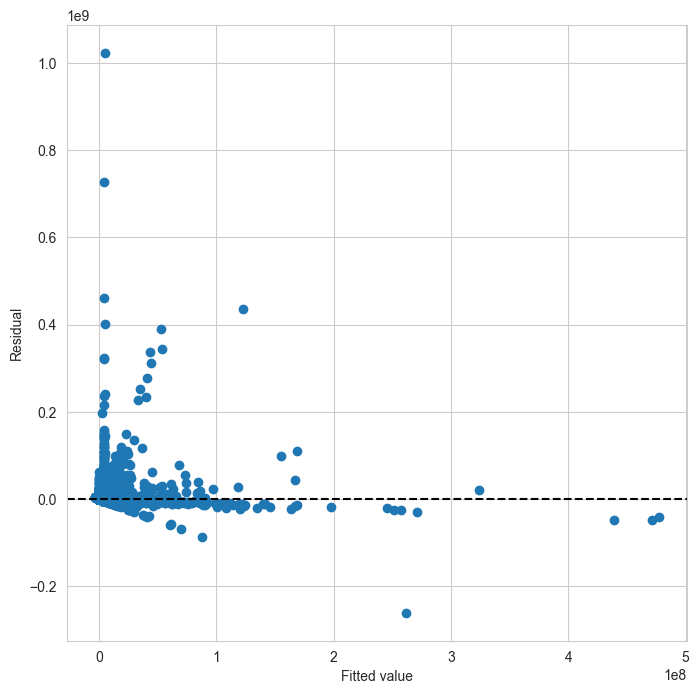

In [21]:
# VISUALIZATION.
df_grouped = test.groupby('naics')[['duty_predicted', 'real_duty']].sum().reset_index()
df_grouped = df_grouped.sort_values(by='real_duty', ascending=False)

# DIAGNOSTIC PLOTS
ax = subplots(figsize=(8,8))[1]
ax.scatter(regression_model.fittedvalues, regression_model.resid)
# residuals vs y^ or X is SLR
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--'); # horizontal black dashed line for reference

37767

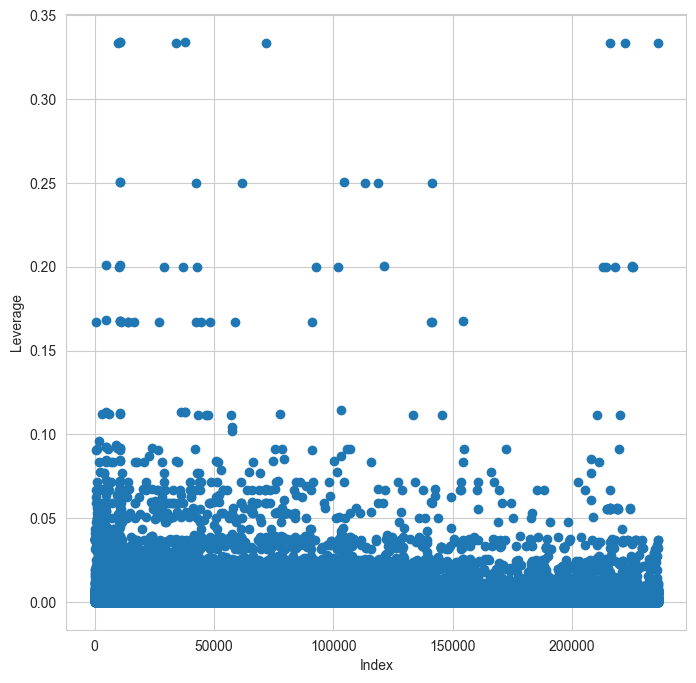

In [22]:
infl = regression_model.get_influence()
ax = subplots(figsize=(8,8))[1]

ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
# X.shape[0] return 1st number in tuple returned by X.shape (aka no. of rows)
# 2nd arg (attribute of 'infl') computes leverage statistic for any number of predictors

ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag) # Identify the index of the largest element of an array

What do we conclude from the graph?

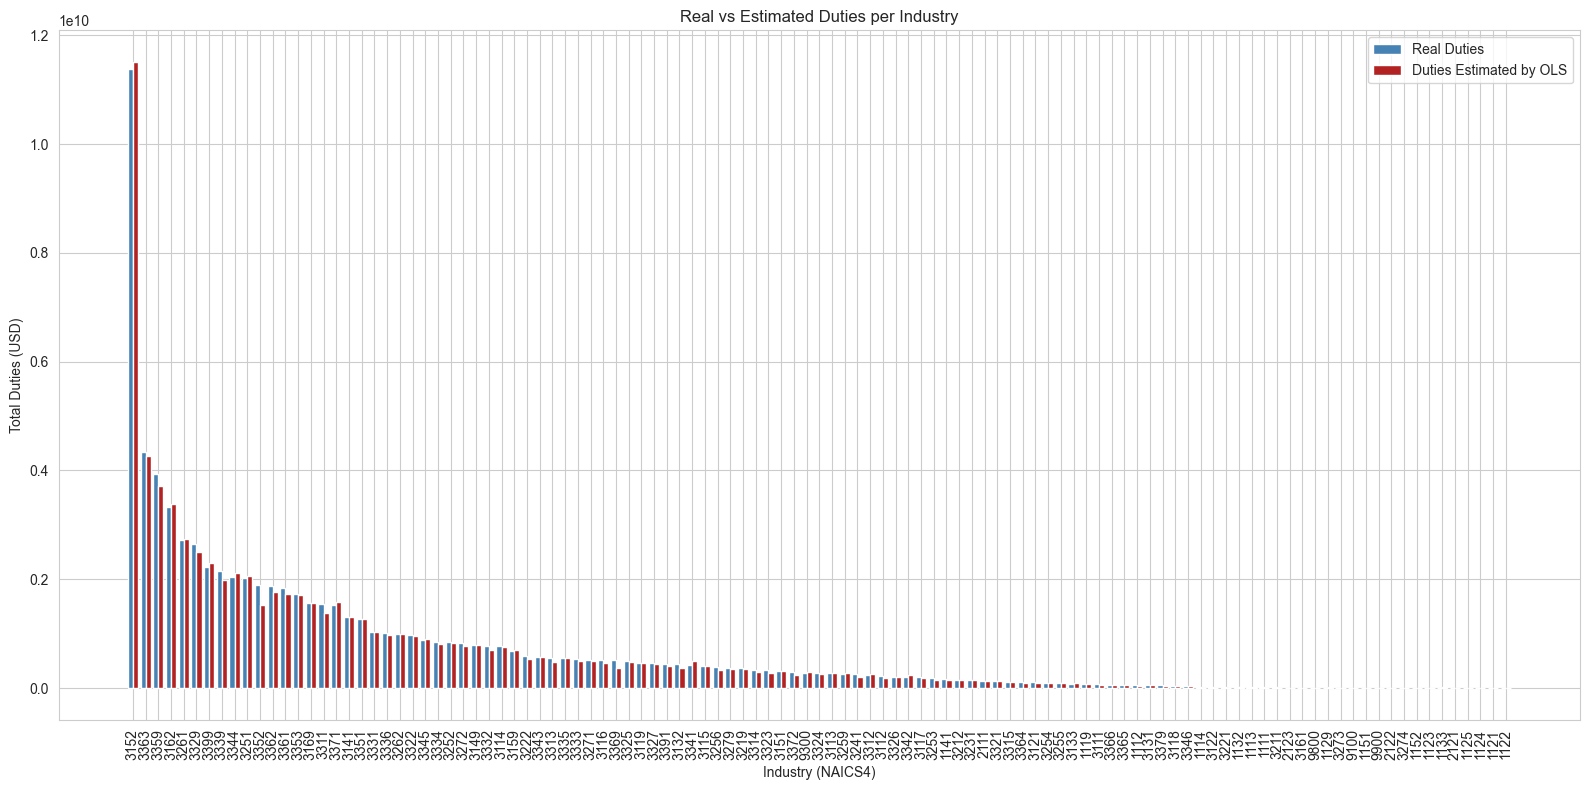

In [ ]:
sns.set_style("whitegrid")
x = range(len(df_grouped)) # Number of naics codes

plt.bar(x, df_grouped['real_duty'], color='steelblue', width=0.4, label='Real Duties')
plt.bar([i + 0.4 for i in x], df_grouped['duty_predicted'], color='firebrick', width=0.4, label='Duties Estimated by OLS')
plt.xticks([i + 0.2 for i in x], df_grouped['naics'], rotation=90)

plt.ylabel('Total Duties (USD)')
plt.xlabel('Industry (NAICS4)')
plt.title('Real vs Estimated Duties per Industry')
plt.legend()
plt.tight_layout()
plt.show();

#### It might be the case to look at specific critical sectors for override + interesting to implement TPU